In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pystrata.motion import TimeSeriesMotion
import pystrata

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] =120

In [3]:
EQNAME = 'ChiChi'

### Συναρτηση εισαγωγής διέγερσης από txt αρχείο

In [4]:
def time_accel_txt_to_pystrata_motion(filename: str) -> TimeSeriesMotion:
    df = pd.read_csv(filename, header=None, skiprows=2, encoding = "utf-8", delim_whitespace=True)
    accels = df[1].to_numpy()
    time_step = df[0][1] - df[0][0]

    return TimeSeriesMotion(filename=filename, description='', time_step=time_step, accels=accels)

### Ειδαγωγή διέγερσης

In [5]:
ts =  time_accel_txt_to_pystrata_motion(f'{EQNAME}.txt')
# print(ts.accels)
# print(ts.time_step)

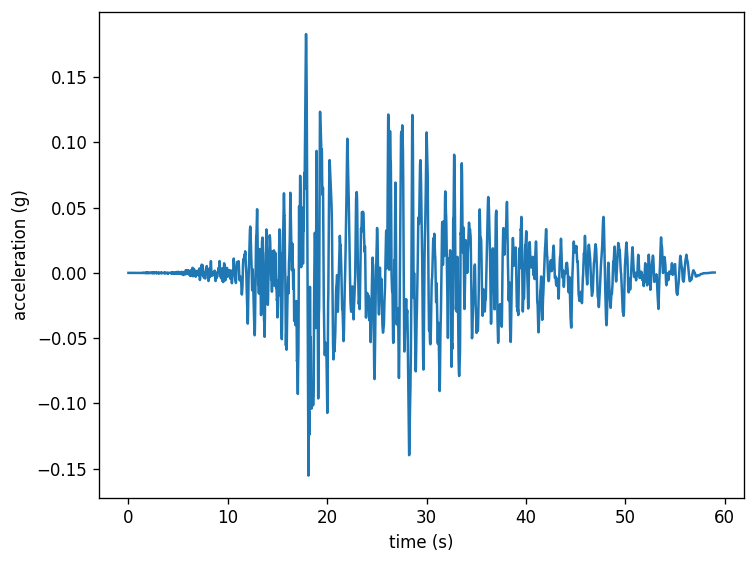

In [6]:
fig, ax = plt.subplots()
ax.plot(ts.times, ts.accels)
ax.set(xlabel='time (s)', ylabel='acceleration (g)')
fig.tight_layout()

## Εισαγωγή εδαφικών στρώσεων

In [7]:
list_layers = []

list_layers.append(pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(16.0, plas_index=0, ocr=1, stress_mean=40),
            5,
            140,
        ))

list_layers.append(pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=25, ocr=1, stress_mean=215),
            15,
            250,
        ))

list_layers.append(pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(20.0, plas_index=0, ocr=1, stress_mean=650),
            30,
            450,
        ))

list_layers.append(pystrata.site.Layer(pystrata.site.SoilType("Rock", 23.0, None, 0.02), 0, 1200))

In [8]:
type(list_layers[0])

pystrata.site.Layer

In [9]:
profile = pystrata.site.Profile(list_layers).auto_discretize()

In [10]:
# profile = pystrata.site.Profile(
#     [
#         pystrata.site.Layer(
#             pystrata.site.DarendeliSoilType(16.0, plas_index=0, ocr=1, stress_mean=40),
#             5,
#             140,
#         ),
#         pystrata.site.Layer(
#             pystrata.site.DarendeliSoilType(18.0, plas_index=25, ocr=1, stress_mean=215),
#             15,
#             250,
#         ),
#         pystrata.site.Layer(
#             pystrata.site.DarendeliSoilType(20.0, plas_index=0, ocr=1, stress_mean=650),
#             30,
#             450,
#         ),
#         pystrata.site.Layer(pystrata.site.SoilType("Rock", 23.0, None, 0.02), 0, 1200),
#     ]
# ).auto_discretize()

In [11]:
# calcs = [
#     pystrata.propagation.EquivalentLinearCalculator(strain_limit=sl)
#     for sl in [0.01, 0.02]
# ]

calc = pystrata.propagation.EquivalentLinearCalculator()
# calc = pystrata.propagation.EquivalentLinearCalculator(strain_limit=0.02)

In [12]:
type(calc)

pystrata.propagation.EquivalentLinearCalculator

In [18]:
freqs = np.logspace(-0.5, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.MaxStrainProfile(),
    ]
)

In [19]:
motion = pystrata.motion.TimeSeriesMotion(f'{EQNAME}.txt', description='', time_step=ts.time_step, accels=ts.accels)

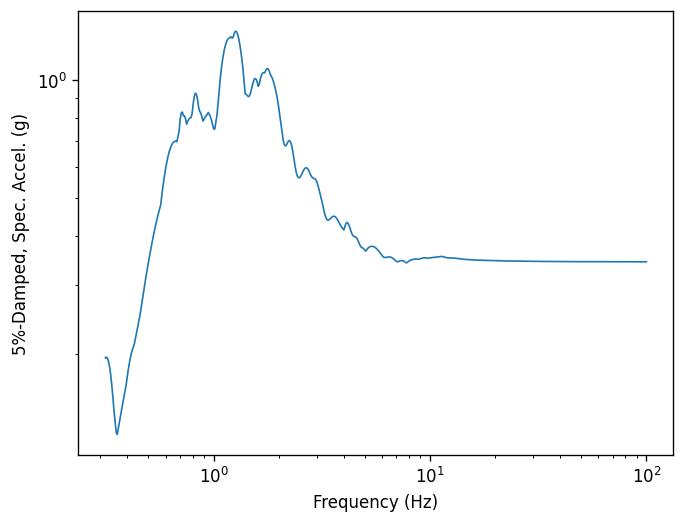

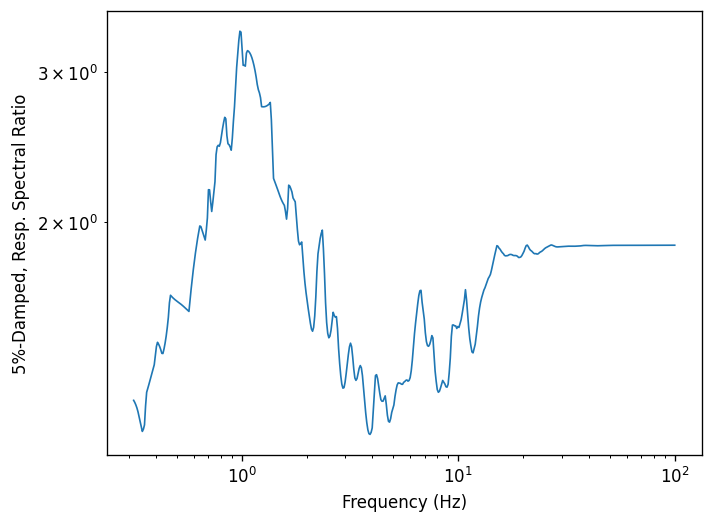

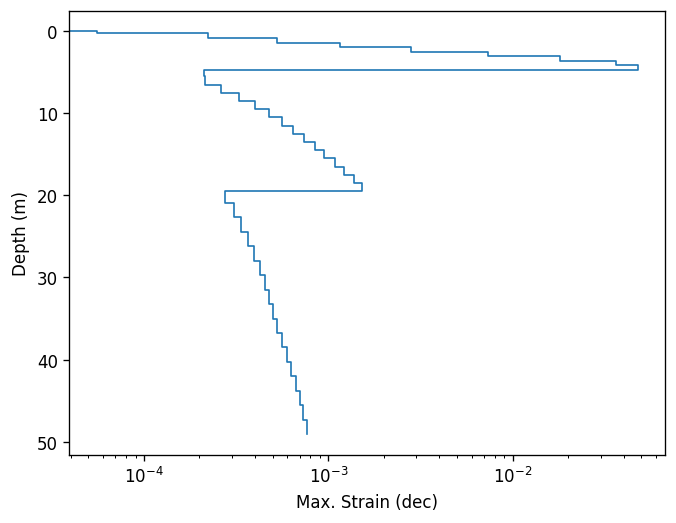

In [20]:
calc(motion, profile, profile.location("outcrop", index=-1))
outputs(calc)
for o in outputs:
    ax = o.plot(style="indiv")

In [16]:
df = outputs[0].to_dataframe()
df.to_excel(f'{EQNAME}.xlsx', index=True)

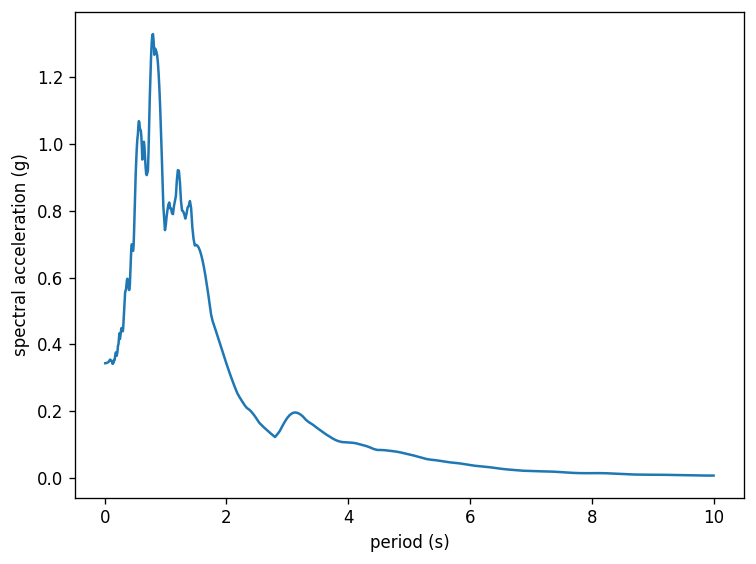

In [17]:
freqs = df.index.to_numpy()
sas = np.flip(df['r1'].to_numpy())
periods = np.flip(1/freqs)

fig, ax = plt.subplots()
ax.plot(periods, sas)
ax.set(xlabel='period (s)', ylabel='spectral acceleration (g)')
fig.tight_layout()

